In [1]:
import os
import random
data_folder = "./data/train"

os.listdir(data_folder)[5:10]

['cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg']

In [2]:
images = []
labels = []
categories = {"cat": 0, "dog": 1}

all_images = os.listdir(data_folder)
#shuffle to mix cat and dogs
random.shuffle(all_images)

for file in all_images:
    if not file.endswith('.jpg'):
        continue
    image_path = os.path.join(data_folder, file)
    #cat.1000.jpg
    label = file.split(".")[0]
    labels.append(categories[label])
    
    images.append(image_path)
    
    
print(images[:3])
print(labels[:3])

['./data/train/cat.6476.jpg', './data/train/cat.4809.jpg', './data/train/cat.1712.jpg']
[0, 0, 0]


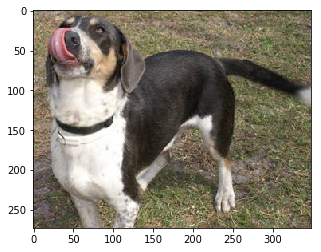

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
display_img = mpimg.imread(images[6])
plt.imshow(display_img)

In [4]:
import cv2
import numpy as np

width = 64
height = 64

#training_size = 5000
training_size = 1000
test_size = 500
total_size = training_size + test_size

images = images[:total_size]
labels = labels[:total_size]

In [5]:
X = np.zeros([total_size, width, height, 3])

for i, image in enumerate(images):
    img = cv2.imread(image)
    resized_img = cv2.resize(img, (width, height))
    X[i] = resized_img
print(X.shape)



(1500, 64, 64, 3)


In [ ]:
#one hot encoding
# cats: 0 == [1, 0]
# dogs: 1 == [0, 1]

Y = np.zeros([total_size, 2])

for i, label in enumerate(labels):
    Y[i][label] = 1
    
print(Y.shape)
print(Y[:10])

In [ ]:
X_train = X[:training_size]
Y_train = Y[:training_size]

X_test = X[training_size:]
Y_test = Y[training_size:]

In [ ]:
import tensorflow as tf

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

def create_model():
    tf.reset_default_graph()

    img_prep = ImagePreprocessing()
    # Zero Center (With mean computed over the whole dataset)
    img_prep.add_featurewise_zero_center()
    # STD Normalization (With std computed over the whole dataset)
    img_prep.add_featurewise_stdnorm()

    # Create extra synthetic training data by flipping, rotating and blurring the
    # images on our data set.
    img_aug = ImageAugmentation()
    img_aug.add_random_flip_leftright()
    img_aug.add_random_rotation(max_angle=25.)
    img_aug.add_random_blur(sigma_max=3.)

    # Define our network architecture:

    # Input is a 64x64 x3(red, green and blue)
    network = input_data(shape=[None, width, height, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)

    # Step 1: Convolution
    network = conv_2d(network, 32, 3, activation='relu')

    # Step 2: Max pooling
    network = max_pool_2d(network, 2)

    # Step 3: Convolution again
    network = conv_2d(network, 64, 3, activation='relu')

    # Step 4: Convolution yet again
    network = conv_2d(network, 64, 3, activation='relu')

    # Step 5: Max pooling again
    network = max_pool_2d(network, 2)

    # Step 6: Fully-connected 512 node neural network
    network = fully_connected(network, 512, activation='relu')

    # Step 7: Dropout - throw away some data randomly during training to prevent over-fitting
    network = dropout(network, 0.5)

    # Step 8: Fully-connected neural network with two outputs (0=isn't a bird, 1=is a bird) to make the final prediction
    network = fully_connected(network, 2, activation='softmax')

    # Tell tflearn how we want to train the network
    network = regression(network, optimizer='adam',
                         loss='categorical_crossentropy',
                         learning_rate=0.0005)

    # Wrap the network in a model object
    model = tflearn.DNN(network, 
                        tensorboard_verbose=1,
                        tensorboard_dir='tmp/')
    
    return model

In [ ]:
model = create_model()

# Train it! We'll do 100 training passes and monitor it as it goes.
model.fit(X_train, Y_train, n_epoch=1, shuffle=True, validation_set=0.1,
          show_metric=True, batch_size=50,
          snapshot_epoch=True,
          run_id='cat-dog-classifier')

# Save model when training is complete to a file
#model.save("testing/test.tfl")
print("Network trained and saved!")

In [ ]:
model = create_model()

model.load("pretrained/catdog5k_128x128_100e.tfl")

predictions = model.predict(X_test)

print(predictions[0])
print(Y_test[0])

In [ ]:
pred_label = np.argmax(predictions, axis=1)
real_label = np.argmax(Y_test, axis=1)

accuracy = np.sum(pred_label == real_label)/test_size

print(accuracy) #75%